## Paquid Data Test

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from jmstate import MultiStateJointModel
from lifelines import ExponentialFitter
import scipy
from sklearn.neighbors import KernelDensity
from jmstate.utils import *

In [45]:
# Lecture du fichier CSV
paquid = pd.read_csv('Data/paquid.csv')

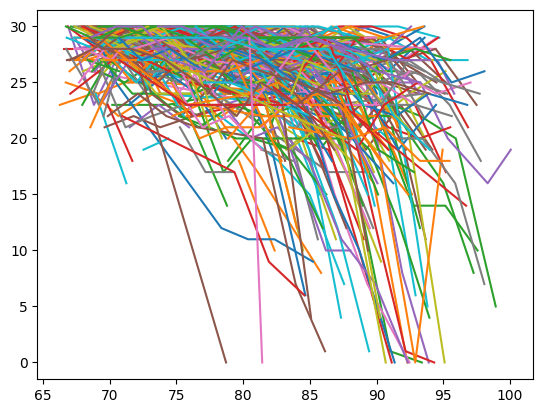

In [46]:
def get_ages(id):
    T = []
    for k in range(4):
        mask = (paquid['ID'].values == id) & (paquid['HIER'].values == k)
        if sum(mask) > 0:
            T.append((min(paquid['age'][mask]), k))

    if len(T) <= 1:
        return T
    
    result = [T[0]]  
    
    for i in range(1, len(T)):
        if T[i][0] >= result[-1][0]:
            result.append(T[i])
    
    return result

get_last_visit_age = lambda id: paquid[paquid['ID'] == id]['age'].max()
get_t = lambda id: torch.tensor(paquid[paquid['ID'] == id]['age'].values)
get_X = lambda id: torch.tensor(paquid[paquid['ID'] == id]['CEP'].min())
get_Y = lambda id: torch.tensor(paquid[paquid['ID'] == id]['MMSE'].values)

ids = range(1, 501)
trajectories = [get_ages(id) for id in ids]
c = torch.tensor([get_last_visit_age(id) for id in ids])
t = torch.nn.utils.rnn.pad_sequence([get_t(id) for id in ids], batch_first=True, padding_value=torch.nan)
x = torch.tensor([[get_X(id)] for id in ids])
y = torch.nn.utils.rnn.pad_sequence([get_Y(id) for id in ids], batch_first=True, padding_value=torch.nan)[..., None]

plt.plot(t.T, y[:, :, 0].T)
plt.show()

In [47]:
buckets = build_buckets(trajectories)
print(buckets.keys())

dict_keys([(1, 3), (0, 1), (1, 2), (0, 2), (2, 3), (0, 3)])


In [48]:
surv_params = {}
for key, value in buckets.items():
    _, t0, t1 = buckets[key]
    exp_fit = ExponentialFitter().fit(t1 - t0)
    surv_params[key] = torch.tensor(exp_fit.lambda_, dtype=torch.float32)

In [49]:
def log_exp(t1, t0, log_lambda):
    return log_lambda

def sigmoid(t, x, psi):
    a = psi[:, [0]]
    b = torch.exp(psi[:, [1]])
    c = psi[:, [2]]

    res = a * torch.sigmoid(b * (c - t))
    return res[:, :, None] 

def link(t, x, psi):
    a = psi[:, [0]]
    b = torch.exp(psi[:, [1]])
    c = psi[:, [2]]

    s = torch.sigmoid(b * (c - t))      

    f = a * s                 
    fp = -a * b * s * (1.0 - s)  

    return torch.stack((f, fp), dim=2)  

f = lambda gamma, b: gamma + b

In [50]:
surv = {
    key: (lambda t0, t1: log_exp(t0, t1, torch.log(surv_params[key])), link)
    for key in buckets.keys()
}

init_gamma = torch.tensor([28.0945,  1.7328, 91.8791])
init_Q_inv = torch.tensor([-0.6639, -0.6833, -1.5302])
init_R_inv = torch.zeros(1)

init_alphas = {
    key: torch.zeros(2)
    for key in buckets.keys()
}

init_betas = {
    key: torch.zeros(1)
    for key in buckets.keys()
}

init_params = ModelParams(
    init_gamma,
    (init_Q_inv, "diag"),
    (init_R_inv, "ball"),
    init_alphas,
    init_betas
)

model_design = ModelDesign(
    f,
    sigmoid,
    surv,
)

model = MultiStateJointModel(model_design, init_params)

In [51]:
data = ModelData(
    x,
    t,
    y,
    trajectories,
    c
)

In [ ]:
history = []
callback = lambda : history.append([p.detach().clone() for p in model.params_.as_list])
model.fit(data, n_iter=5000, callback=callback)

Fitting joint model: 100%|██████████| 500/500 [00:19<00:00, 25.47it/s]


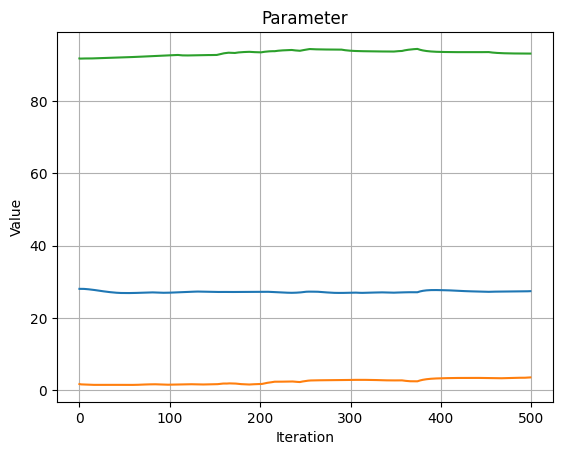

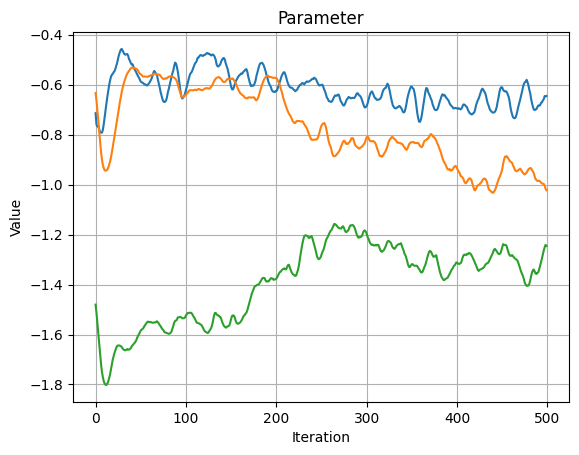

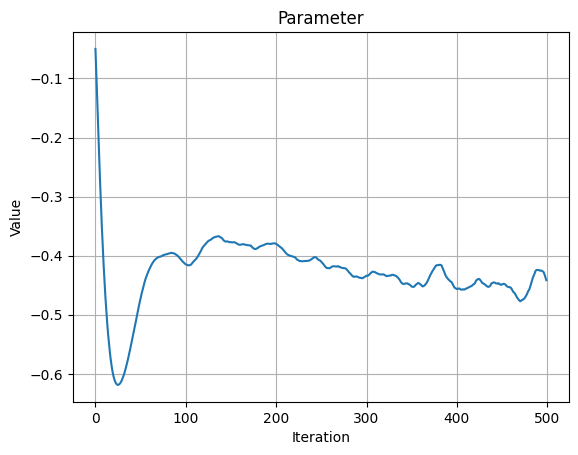

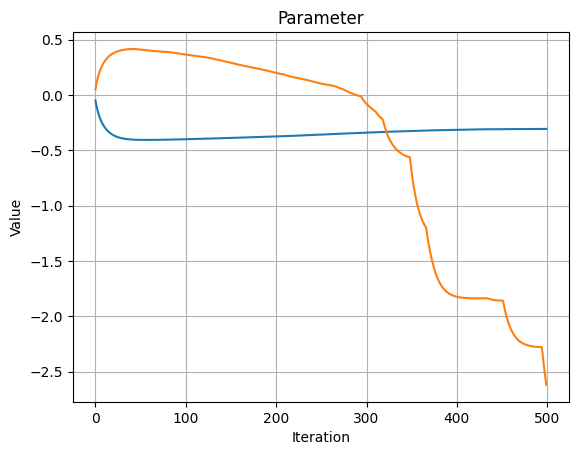

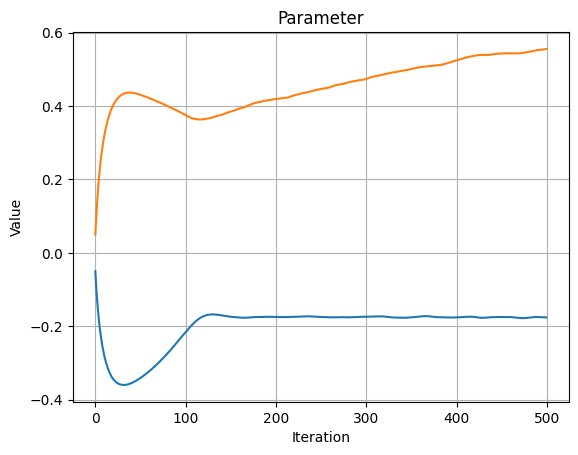

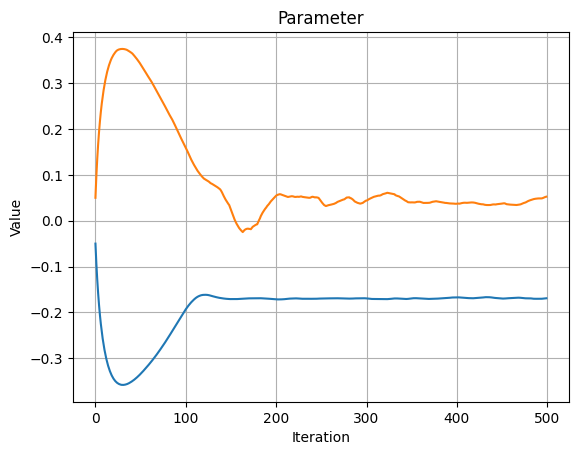

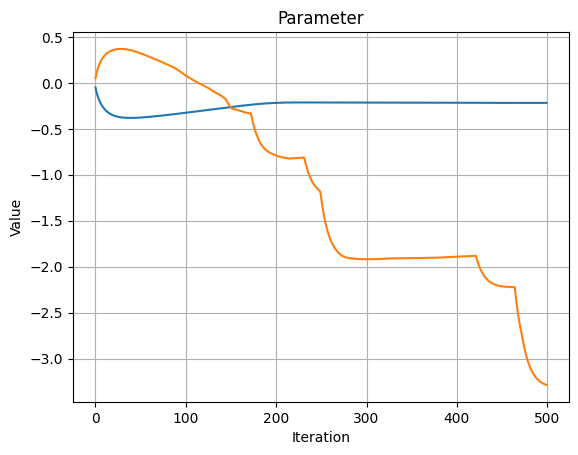

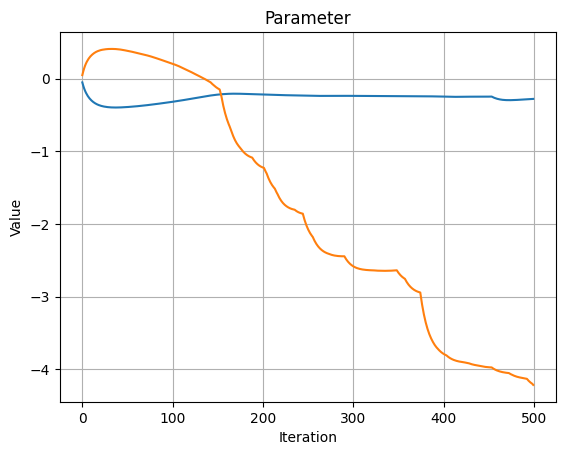

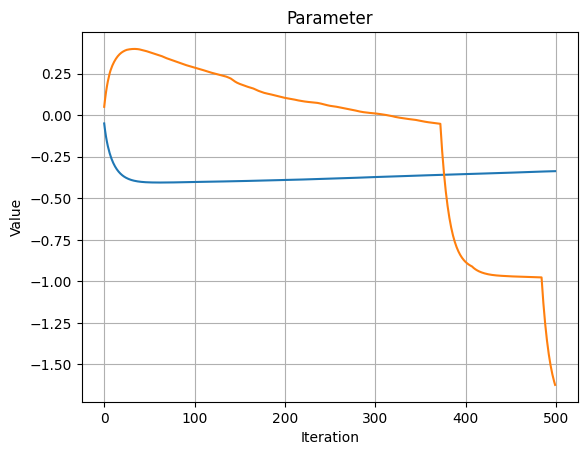

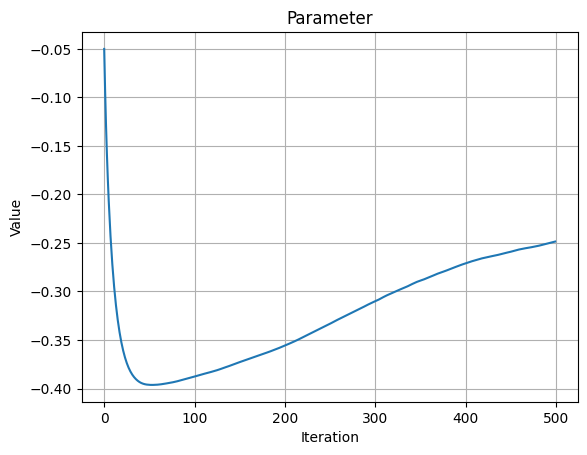

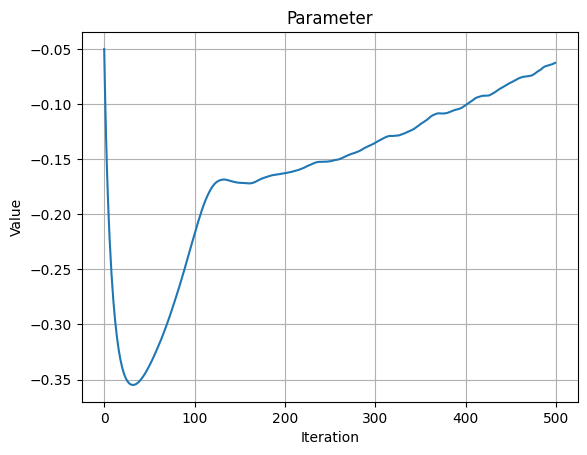

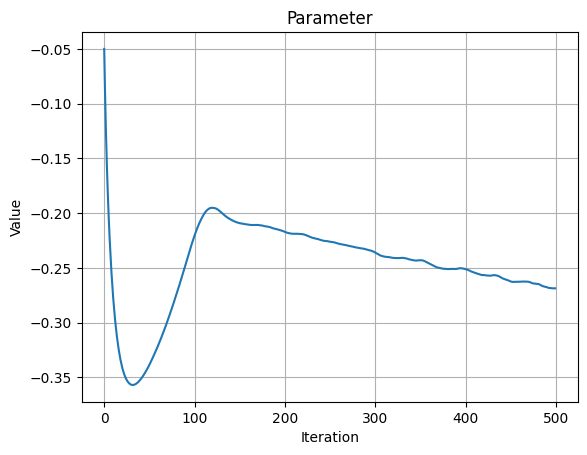

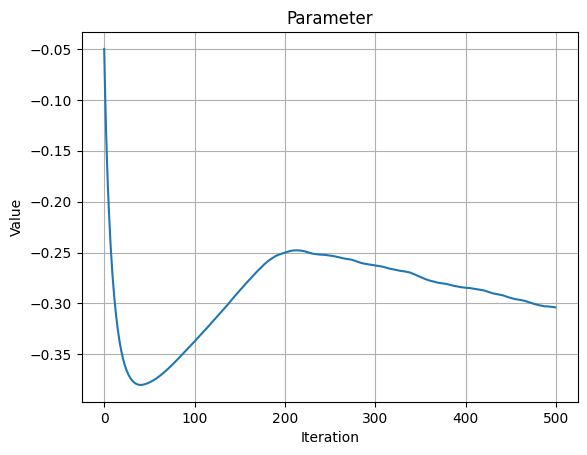

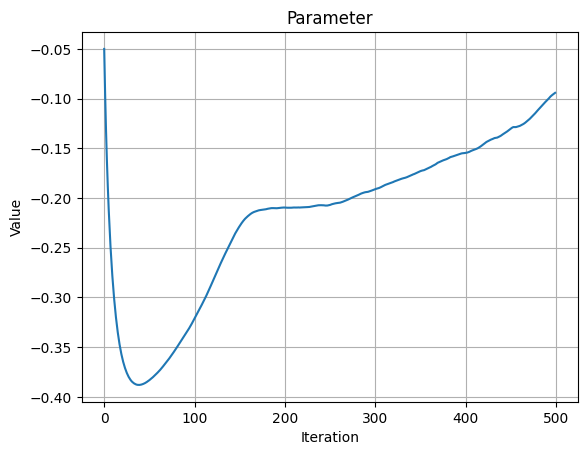

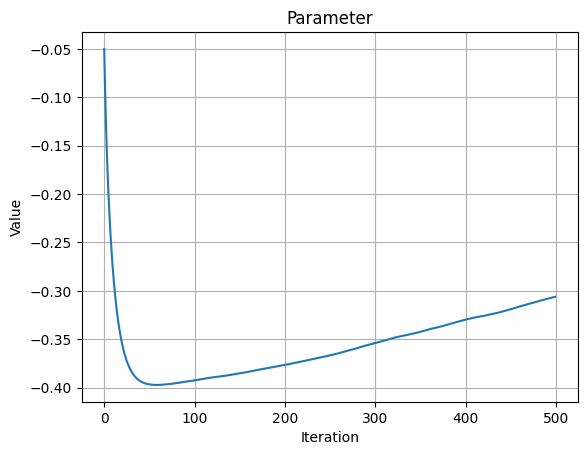

In [53]:

for i in range(len(history[0])):
    history_vstack = np.vstack([elt[i].numpy().reshape(1, -1) for elt in history])

    for j in range(history_vstack.shape[1]):
        plt.plot(np.arange(history_vstack.shape[0]), history_vstack[:, j])

    plt.title(f"Parameter")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [ ]:
print(model.params_)

ModelParams(gamma=tensor([27.4027,  3.5285, 93.1740], requires_grad=True), Q_repr=(tensor([-0.6452, -1.0227, -1.2455], requires_grad=True), 'diag'), R_repr=(tensor([-0.4415], requires_grad=True), 'ball'), alphas={(1, 3): tensor([-0.3068, -2.6199], requires_grad=True), (0, 1): tensor([-0.1756,  0.5556], requires_grad=True), (1, 2): tensor([-0.1692,  0.0524], requires_grad=True), (0, 2): tensor([-0.2177, -3.2871], requires_grad=True), (2, 3): tensor([-0.2774, -4.2156], requires_grad=True), (0, 3): tensor([-0.3371, -1.6230], requires_grad=True)}, betas={(1, 3): tensor([-0.2485], requires_grad=True), (0, 1): tensor([-0.0627], requires_grad=True), (1, 2): tensor([-0.2687], requires_grad=True), (0, 2): tensor([-0.3038], requires_grad=True), (2, 3): tensor([-0.0942], requires_grad=True), (0, 3): tensor([-0.3062], requires_grad=True)})


ValueError: Fisher Information Matrix must be previously computed. CIs may not be computed.

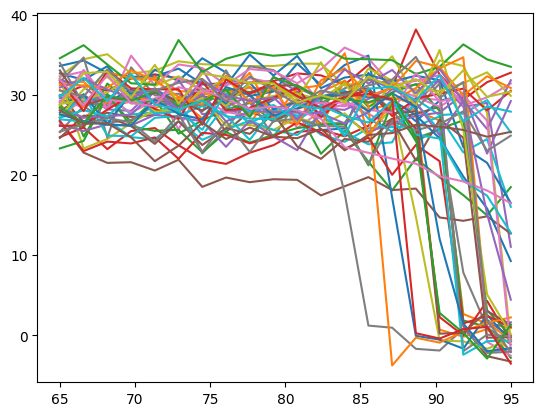

In [ ]:
N = 50

Q = model.params_.get_precision("Q").detach()
Q = torch.linalg.inv(Q)

R = model.params_.get_precision("R").detach()
R = torch.linalg.inv(R)

b_sim = torch.randn(N, model.params_.gamma.detach().shape[0]) @ torch.tensor(scipy.linalg.sqrtm(Q.numpy()))
psi_sim = f(model.params_.gamma, b_sim)
x_sim = KernelDensity().fit(x).sample(N)

y_sim = model.model_design.h(torch.linspace(65, 95, 20), x_sim, psi_sim)
y_sim += torch.randn_like(y_sim) @ torch.tensor(scipy.linalg.sqrtm(R.numpy()))
plt.plot(torch.linspace(65, 95, 20), y_sim.squeeze(-1).T.detach().numpy())
plt.show()

In [ ]:
trajectories_init = [trajectory[:1] for trajectory in trajectories[:n]]

sample_data = SampleData(x_sim, trajectories_init, psi_sim)

trajectories_sim = model.sample_trajectories(sample_data, [95.0 for _ in range(n)])

In [ ]:
print(trajectories_sim)

[[(68.5063, 2), (94.47406768798828, 3)], [(66.9954, 1), (90.91487121582031, 2)], [(72.5924, 1), (82.33212280273438, 2), (82.33232116699219, 3)], [(73.9535, 1), (82.34820556640625, 2), (82.37677764892578, 3)], [(68.3984, 0), (71.25924682617188, 2), (89.62886047363281, 3)], [(73.1908, 0), (80.00518798828125, 1), (86.52812194824219, 2), (86.74298095703125, 3)], [(85.5787, 2), (90.20467376708984, 3)], [(74.229, 1), (82.82791137695312, 2), (92.51065063476562, 3)], [(80.7755, 1), (92.64479064941406, 2), (92.76094055175781, 3)], [(81.0601, 1), (83.26181030273438, 2), (91.67839050292969, 3)], [(83.6773, 2), (84.96669006347656, 3)], [(74.8984, 1), (81.34271240234375, 2), (81.37459564208984, 3)], [(84.3357, 1), (85.91803741455078, 2), (86.59500122070312, 3)], [(78.815, 2), (94.32951354980469, 3)], [(71.6429, 1), (79.62164306640625, 2), (91.54611206054688, 3)], [(84.2728, 2), (90.53340148925781, 3)], [(69.8426, 0), (84.91607666015625, 2), (90.09590148925781, 3)], [(70.3315, 0), (74.8860855102539,